Loaded training data from: Training/Logs/training_data.json
  Saved at        : 2025-11-19T09:13:48.515897
  Total timesteps : 6144
  Episode count   : 0
  Step snapshots  : 61


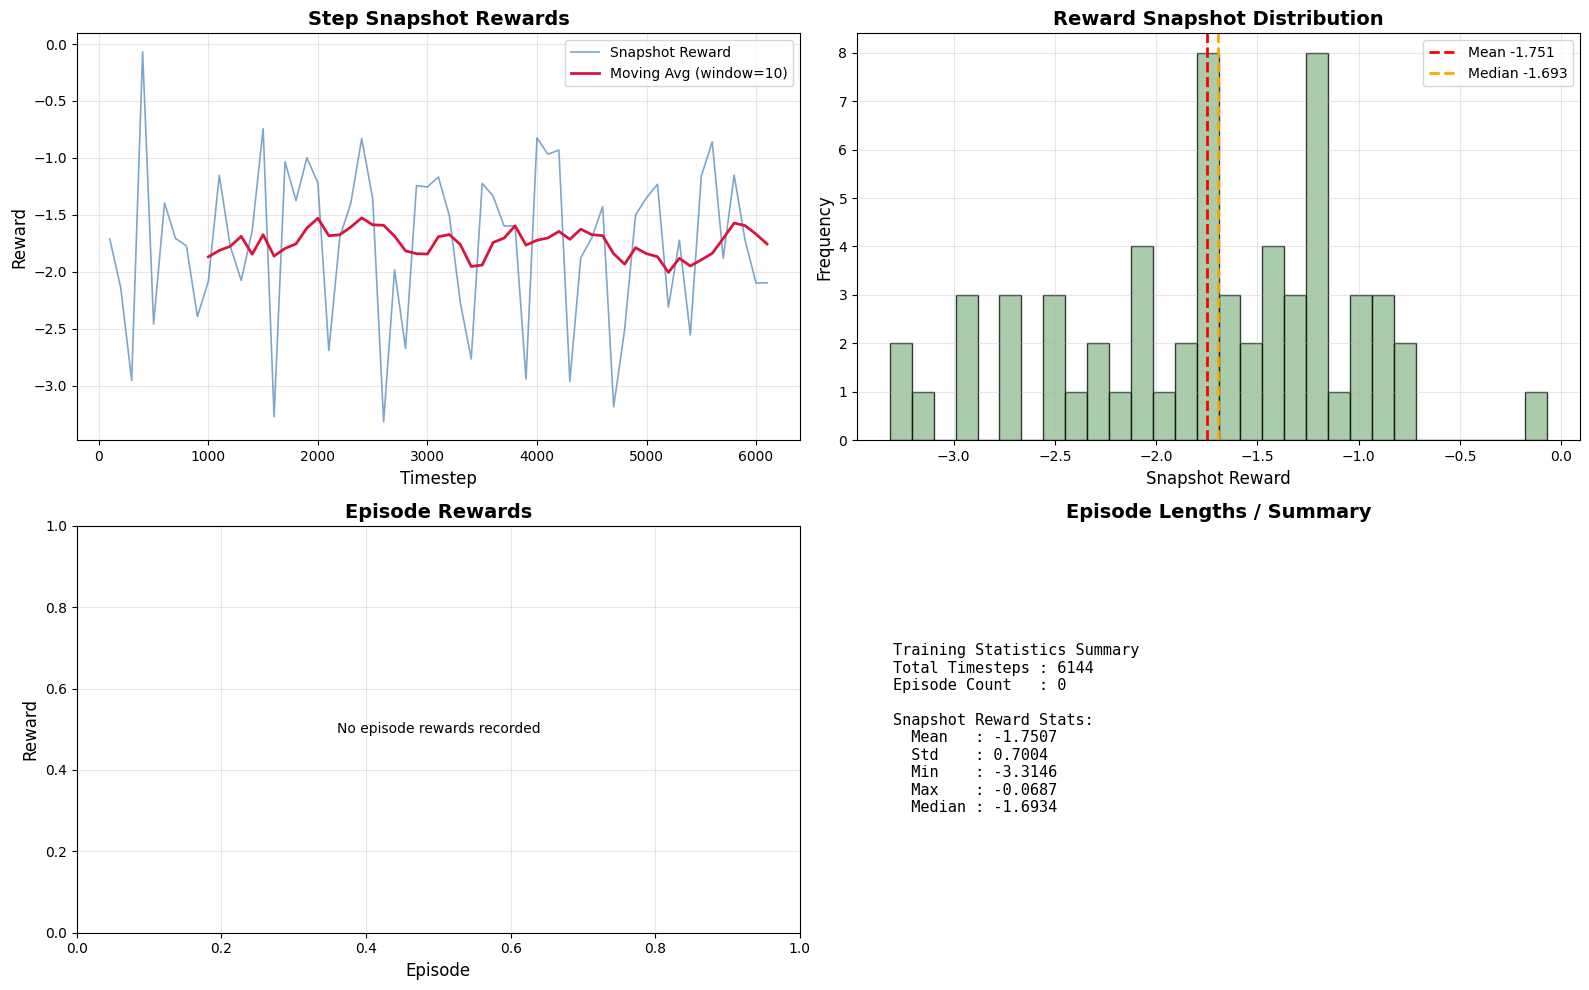


TRAINING DATA SUMMARY
Saved at        : 2025-11-19T09:13:48.515897
Total timesteps : 6144
Episode count   : 0
Snapshots       : 61 (every N/A steps if configured)

Snapshot Reward Stats -> mean -1.7507, std 0.7004, min -3.3146, max -0.0687

Sample Step Snapshot:
{'timestep': 100, 'reward': -1.7100443840026855, 'sim_time': 1.099999999999445, 'forward_speed': 0.4187646432679055, 'lateral_speed': 8.375321195053891e-13, 'velocity_projection': 0.07697892024475234, 'episode': 0, 'captured_at': '2025-11-19T09:13:16.011116'}


SystemExit: 0

/Users/wenqifan/Desktop/RL-ElasticaSnake/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
"""
Visualization script for training logs
Visualizes consolidated data stored in training_data.json
"""

import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, Any


def load_training_data(logs_dir: str = "Training/Logs") -> Dict[str, Any]:
    """Load unified training data JSON produced by RewardCallback"""
    logs_path = Path(logs_dir)
    training_data_file = logs_path / "training_data.json"
    if not training_data_file.exists():
        raise FileNotFoundError(f"training_data.json not found in {logs_dir}")

    with open(training_data_file, "r") as f:
        training_data = json.load(f)

    metadata = training_data.get("metadata", {})
    print(f"Loaded training data from: {training_data_file}")
    print(f"  Saved at        : {metadata.get('saved_at', 'unknown')}")
    print(f"  Total timesteps : {metadata.get('total_timesteps', 'unknown')}")
    print(f"  Episode count   : {metadata.get('episode_count', 0)}")
    print(f"  Step snapshots  : {len(training_data.get('steps', []))}")
    return training_data


def _extract_step_arrays(step_entries: list[dict]) -> tuple[np.ndarray, np.ndarray]:
    """Return arrays for timesteps and rewards from step snapshots"""
    if not step_entries:
        return np.array([]), np.array([])
    timesteps = np.array([entry.get("timestep", idx) for idx, entry in enumerate(step_entries)], dtype=float)
    rewards = np.array([entry.get("reward", 0.0) for entry in step_entries], dtype=float)
    return timesteps, rewards


def visualize_training_data(training_data: Dict[str, Any], save_figures: bool = True, output_dir: str = "Training/Logs") -> None:
    """Create visualizations for consolidated training_data.json"""
    metadata = training_data.get("metadata", {})
    episodes = training_data.get("episodes", {})
    step_entries = training_data.get("steps", [])

    step_info_keys = metadata.get("step_info_keys", [])
    timesteps, step_rewards = _extract_step_arrays(step_entries)

    episode_rewards = episodes.get("rewards", [])
    episode_lengths = episodes.get("lengths", [])

    fig = plt.figure(figsize=(16, 10))

    # 1. Step reward snapshots over time
    ax1 = plt.subplot(2, 2, 1)
    if step_rewards.size > 0:
        ax1.plot(timesteps, step_rewards, alpha=0.7, linewidth=1.2, color="steelblue", label="Snapshot Reward")
        window = min(10, len(step_rewards))
        if window > 1:
            moving_avg = np.convolve(step_rewards, np.ones(window) / window, mode="valid")
            ax1.plot(timesteps[window-1:], moving_avg, color="crimson", linewidth=2, label=f"Moving Avg (window={window})")
    else:
        ax1.text(0.5, 0.5, "No step snapshots available", ha="center", va="center", transform=ax1.transAxes)
    ax1.set_xlabel("Timestep", fontsize=12)
    ax1.set_ylabel("Reward", fontsize=12)
    ax1.set_title("Step Snapshot Rewards", fontsize=14, fontweight="bold")
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc="best")

    # 2. Distribution of snapshot rewards
    ax2 = plt.subplot(2, 2, 2)
    if step_rewards.size > 0:
        ax2.hist(step_rewards, bins=min(50, max(10, len(step_rewards)//2)), color="darkseagreen", edgecolor="black", alpha=0.75)
        ax2.axvline(step_rewards.mean(), color="red", linestyle="--", linewidth=2, label=f"Mean {step_rewards.mean():.3f}")
        ax2.axvline(np.median(step_rewards), color="orange", linestyle="--", linewidth=2, label=f"Median {np.median(step_rewards):.3f}")
        ax2.legend()
    else:
        ax2.text(0.5, 0.5, "No snapshot rewards to plot", ha="center", va="center", transform=ax2.transAxes)
    ax2.set_xlabel("Snapshot Reward", fontsize=12)
    ax2.set_ylabel("Frequency", fontsize=12)
    ax2.set_title("Reward Snapshot Distribution", fontsize=14, fontweight="bold")
    ax2.grid(True, alpha=0.3)

    # 3. Episode rewards (if available)
    ax3 = plt.subplot(2, 2, 3)
    if episode_rewards:
        episodes_idx = np.arange(len(episode_rewards))
        ax3.plot(episodes_idx, episode_rewards, marker="o", markersize=4, alpha=0.7, color="mediumpurple", label="Episode Reward")
        if len(episode_rewards) > 5:
            ep_window = min(10, len(episode_rewards))
            ep_avg = np.convolve(episode_rewards, np.ones(ep_window) / ep_window, mode="valid")
            ax3.plot(episodes_idx[ep_window-1:], ep_avg, color="crimson", linewidth=2, label=f"Moving Avg ({ep_window})")
        ax3.legend()
    else:
        ax3.text(0.5, 0.5, "No episode rewards recorded", ha="center", va="center", transform=ax3.transAxes)
    ax3.set_xlabel("Episode", fontsize=12)
    ax3.set_ylabel("Reward", fontsize=12)
    ax3.set_title("Episode Rewards", fontsize=14, fontweight="bold")
    ax3.grid(True, alpha=0.3)

    # 4. Episode lengths or statistics summary
    ax4 = plt.subplot(2, 2, 4)
    if episode_lengths:
        episodes_idx = np.arange(len(episode_lengths))
        ax4.plot(episodes_idx, episode_lengths, marker="s", markersize=4, alpha=0.7, color="teal", label="Episode Length")
        if len(episode_lengths) > 5:
            len_window = min(10, len(episode_lengths))
            len_avg = np.convolve(episode_lengths, np.ones(len_window) / len_window, mode="valid")
            ax4.plot(episodes_idx[len_window-1:], len_avg, color="crimson", linewidth=2, label=f"Moving Avg ({len_window})")
        ax4.legend()
        ax4.set_ylabel("Length (steps)")
    else:
        summary = [
            "Training Statistics Summary",
            f"Total Timesteps : {metadata.get('total_timesteps', 'N/A')}",
            f"Episode Count   : {metadata.get('episode_count', 0)}",
            "",
        ]
        if step_rewards.size > 0:
            summary.extend([
                "Snapshot Reward Stats:",
                f"  Mean   : {step_rewards.mean():.4f}",
                f"  Std    : {step_rewards.std():.4f}",
                f"  Min    : {step_rewards.min():.4f}",
                f"  Max    : {step_rewards.max():.4f}",
                f"  Median : {np.median(step_rewards):.4f}",
            ])
        else:
            summary.append("No snapshot rewards available")
        ax4.text(0.05, 0.5, "\n".join(summary), ha="left", va="center", fontsize=11, family="monospace", transform=ax4.transAxes)
        ax4.axis("off")
    ax4.set_xlabel("Episode", fontsize=12)
    ax4.set_title("Episode Lengths / Summary", fontsize=14, fontweight="bold")
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_figures:
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)
        figure_path = output_path / "training_logs_visualization.png"
        plt.savefig(figure_path, dpi=150, bbox_inches="tight")
        print(f"\nFigure saved to: {figure_path}")

    plt.show()

    # Print console summary
    print("\n" + "=" * 70)
    print("TRAINING DATA SUMMARY")
    print("=" * 70)
    print(f"Saved at        : {metadata.get('saved_at', 'unknown')}")
    print(f"Total timesteps : {metadata.get('total_timesteps', 'unknown')}")
    print(f"Episode count   : {metadata.get('episode_count', 0)}")
    print(f"Snapshots       : {len(step_entries)} (every {metadata.get('save_freq', 'N/A')} steps if configured)")
    if step_rewards.size > 0:
        print(f"\nSnapshot Reward Stats -> mean {step_rewards.mean():.4f}, std {step_rewards.std():.4f}, min {step_rewards.min():.4f}, max {step_rewards.max():.4f}")
    if episode_rewards:
        print(f"Episode Reward mean {np.mean(episode_rewards):.4f}, std {np.std(episode_rewards):.4f}")
    if episode_lengths:
        print(f"Episode Length mean {np.mean(episode_lengths):.2f} steps")
    if step_info_keys and step_entries:
        print("\nSample Step Snapshot:")
        print(step_entries[0])
    print("=" * 70)


def main() -> int:
    """Entry point for CLI usage"""
    import argparse

    parser = argparse.ArgumentParser(description="Visualize training_data.json logs")
    parser.add_argument("--logs_dir", type=str, default="Training/Logs", help="Directory containing training_data.json")
    parser.add_argument("--save", action="store_true", help="Save figures to disk")
    parser.add_argument("--output_dir", type=str, default="Training/Logs", help="Directory for saved figures")

    args, _ = parser.parse_known_args()

    try:
        training_data = load_training_data(args.logs_dir)
        visualize_training_data(training_data, save_figures=args.save, output_dir=args.output_dir)
    except FileNotFoundError as exc:
        print(f"Error: {exc}")
        return 1

    return 0


if __name__ == "__main__":
    raise SystemExit(main())

